In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in all the names
names = open('names.txt', 'r').read().splitlines()
print('total no. of names', len(names))
names[:8]

total no. of names 32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):  
  X, Y = [], []
  
  for w in names:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [80]:
max_steps = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    # Forward pass
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)        # Constructing mini batch
    Xb, yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]     # Embedding the generated words.
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])     # Concatenate the different dimension of words.

    a1 = embcat@W1+b1           # Pre activation
    h1 = torch.tanh(a1)         # tanh activation

    logits = h1@W2+b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:
        param.data += -lr * param.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

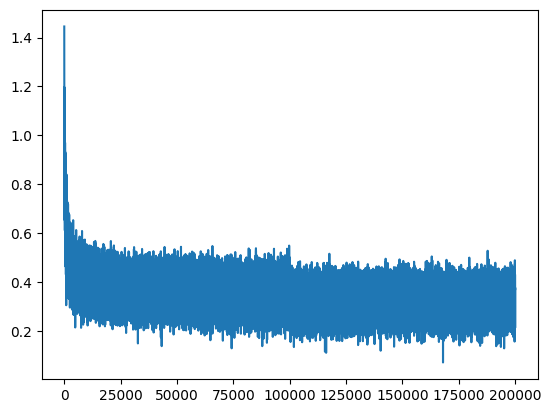

In [81]:
plt.plot(np.arange(len(lossi)), lossi)

In [82]:
print(C[torch.tensor([0, 0, 0])])

tensor([[ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578],
        [ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578],
        [ 1.6669,  0.3794,  0.1780, -0.4677,  0.3983,  0.1968, -1.5768,  1.2646,
          0.8168,  1.5578]], grad_fn=<IndexBackward0>)


In [83]:
# Generate new names based on the trained neural network
for i in range(5):
    out_name = []
    context = [0]*block_size

    while True:
        context_tensor = C[torch.tensor([context])]     # (1, block_size, d)
        a1 = context_tensor.view(context_tensor.shape[0], context_tensor.shape[1]*context_tensor.shape[2]) @ W1 + b1
        h1 = torch.tanh(a1)
        logits = h1 @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out_name.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out_name))

vayani.
yus.
brendir.
zaulie.
allah.


In [84]:
W1.shape

torch.Size([30, 200])

# Changes made to the neural network architecture

In [85]:
# To make the neural network more effective, some changes are need to be made.
x = torch.tensor([0, 0, 5, 0], dtype=float)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print(loss.item())

0.020012253359626975


In [86]:
# To make the neural network more effective, some changes are need to be made.
x = torch.tensor([1, 1, 1, 1], dtype=float)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print(loss.item())

1.3862943611198906


In [87]:
# To make the neural network more effective, some changes are need to be made.
x = torch.randn(4)
y = torch.tensor([2])
prob = torch.softmax(x, dim=0)
loss = -prob[y].log()
print('generated tensor', x)
print(loss.item())

generated tensor tensor([-0.1578,  0.6659,  0.0464,  1.0913])
1.8743177652359009


In [138]:
# Improvements
"""
1. Due to random initialization of weight matrices the the loss can be very large. This is because the random initialization fake confident on wrong labels.
    We can start with normalizing the weight matrix W2, by multiplying 0.01. Mean loss --> 0.33101662471264603. This helps in reducing the initial loss value
    but some problem still persists. The histogram of activation function layer h1 has too many values with values around -1 and 1. This is because tanh compresses values
    in the range of -1 and 1.
2. By normalizing the weight matrix W2, we can further minimize the initial loss and number of extremes (-1, 1) in the activation layer will also decrease.
3. If too many activation layer values are between -1 and 1, the gradient at these values are 0 which has no effect on gradient update (as the deirvative at these points are 0s)
    during back propagation. If for a particular neuron, the activation value is -1 or 1 for all training sample, then the neuron becomes a dead neuron ie the neuron doesn't
    change throughout training. This is called a dead neuron problem.
4. If the distribution of the preactivation function values are too broad (high variance) then activation values has too many extremums.
5. Proper initialization of weights (Kaiming Initialization)[https://arxiv.org/abs/1502.01852]. The key idea behind Kaiming initialization is to set the initial weights of the
    neural network in a way that prevents the variance of activations from vanishing or exploding as information passes through the network. It takes into account the non-linearity
    introduced by ReLU(Similar) activation functions. For a given layer with n input units, the weights are initialized by drawing values from a normal distribution with mean 0
    and a standard deviation of gain/sqrt(fan_in). fan_in is the dimension of feature input. The gain value is differetn for differnt non-linearity. For RelU it is sqrt(2)
    and for tanh it is 5/3.
"""

'\n1. Normalizing the weight matrices W1 and W2, by multiplying 0.01. Mean loss --> 0.3640873616717756\n2. \n'

In [43]:
# Changing weight initialization to mitigate higher loss at initial epoch.
g = torch.Generator().manual_seed(2147483647)                   # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.01       # Step 1: Normalizing the weight matrix reduces the initial loss and also normalize the activation layer.
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/(3*(n_embd*block_size)**0.5))      # Kaiming Initialization. Step 5.
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01       # Step 2: 
b2 = torch.randn(vocab_size,                      generator=g) * 0
params = [C, W1, b1, W2, b2]

In [44]:
for p in params:
  p.requires_grad = True

In [47]:
max_steps = 2000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    # Forward pass
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)        # Constructing mini batch
    Xb, yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]     # Embedding the generated words.
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])     # Concatenate the different dimension of words.

    a1 = embcat@W1+b1           # Pre activation
    h1 = torch.tanh(a1)         # tanh activation

    logits = h1@W2+b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for param in params:
        param.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in params:
        param.data += -lr * param.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 100 == 0:
        print(f'loss at iter {i}: {loss.item()}')

loss at iter 0: 2.3854737281799316
loss at iter 100: 2.375758171081543
loss at iter 200: 2.7153406143188477
loss at iter 300: 2.506196975708008
loss at iter 400: 2.814948558807373
loss at iter 500: 2.354644298553467
loss at iter 600: 2.513533115386963
loss at iter 700: 2.379478693008423
loss at iter 800: 2.6947638988494873
loss at iter 900: 2.616034746170044
loss at iter 1000: 2.554081916809082
loss at iter 1100: 2.160247564315796
loss at iter 1200: 2.341012477874756
loss at iter 1300: 2.551906108856201
loss at iter 1400: 2.212344169616699
loss at iter 1500: 2.424121379852295
loss at iter 1600: 2.2827367782592773
loss at iter 1700: 2.217982292175293
loss at iter 1800: 2.079723358154297
loss at iter 1900: 2.1076834201812744


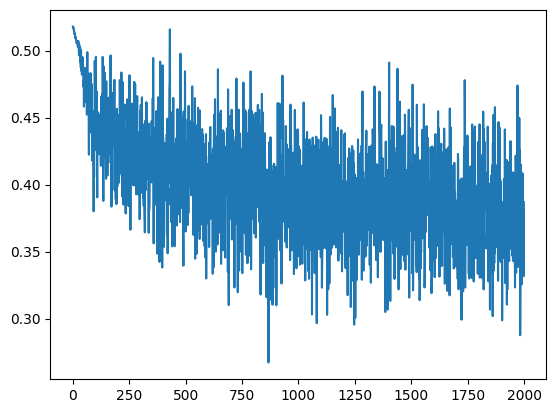

In [37]:
plt.plot(stepi, lossi)
# The loss got improved due to a different initialization.

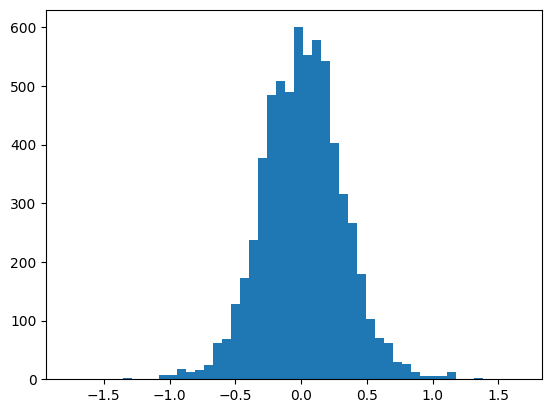

In [38]:
# Plotting the pre activation layer
plt.hist(a1.view(-1).tolist(), bins=50);

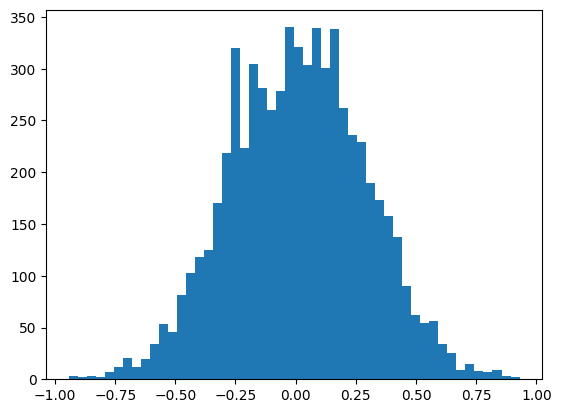

In [39]:
# Plotting the activation layer
plt.hist(h1.view(-1).tolist(), bins=50);

In [142]:
print(np.mean(lossi))

0.33101662471264603


In [ ]:
# Effect of activation function on the neural network. The tanh compress everything between -1 and 1.